Using device: cuda
Approximate mean of u_exact (Example 3.2) on Omega: 1.100083e-03

Network architecture:
BiharmonicNet(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=84, bias=True)
    (1-3): 3 x Linear(in_features=84, out_features=84, bias=True)
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
  (activation): Tanh()
)

Total trainable parameters: 21757


Training Example 3.2 (P4) with PDE residual + CH BCs
Epoch      1 | PDE_loss:  5.9187e+00 | L_bc1:  3.4262e-03 | L_bc2:  2.4635e-01 | LR: 1.00e-03
Epoch    500 | PDE_loss:  2.5370e-01 | L_bc1:  2.3445e-04 | L_bc2:  1.8470e-03 | LR: 1.00e-03
Epoch   1000 | PDE_loss:  1.5333e-01 | L_bc1:  1.6855e-04 | L_bc2:  1.2847e-03 | LR: 1.00e-03
Epoch   1500 | PDE_loss:  8.9412e-02 | L_bc1:  9.3095e-05 | L_bc2:  6.1282e-04 | LR: 1.00e-03
Epoch   2000 | PDE_loss:  6.2891e-02 | L_bc1:  3.5165e-05 | L_bc2:  2.7045e-04 | LR: 1.00e-03
Epoch   2500 | PDE_loss:  2.6895e-02 | L_bc1:  5.1287e-06 | L_bc2:  8.8563e-05 | 

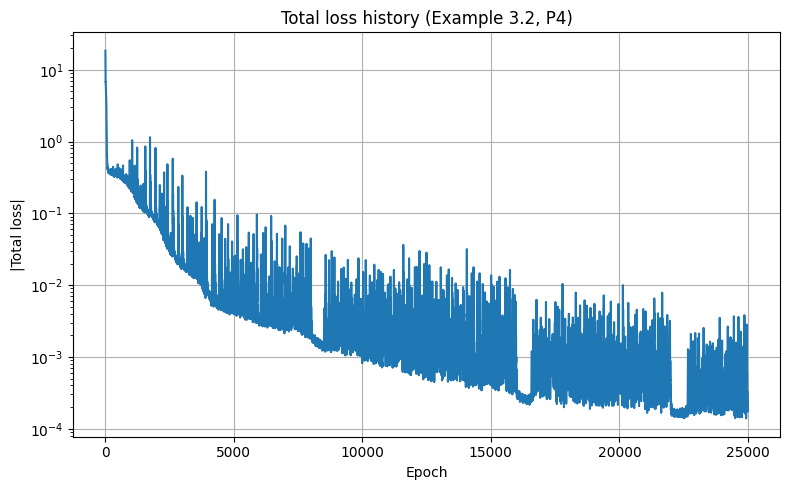

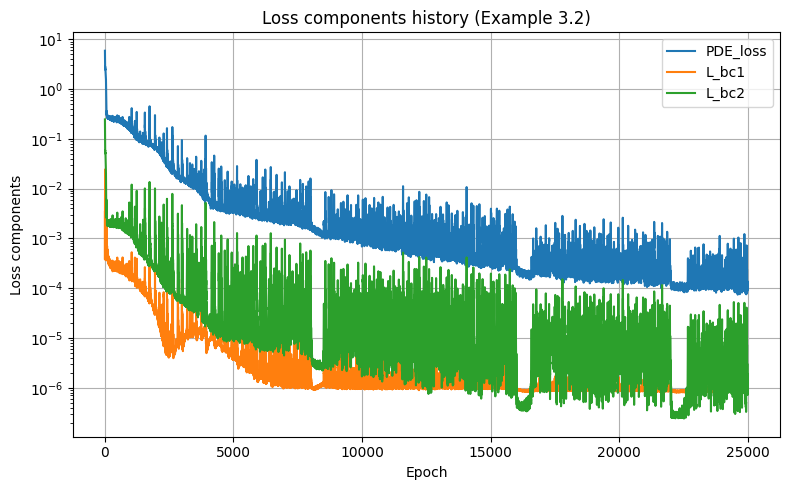

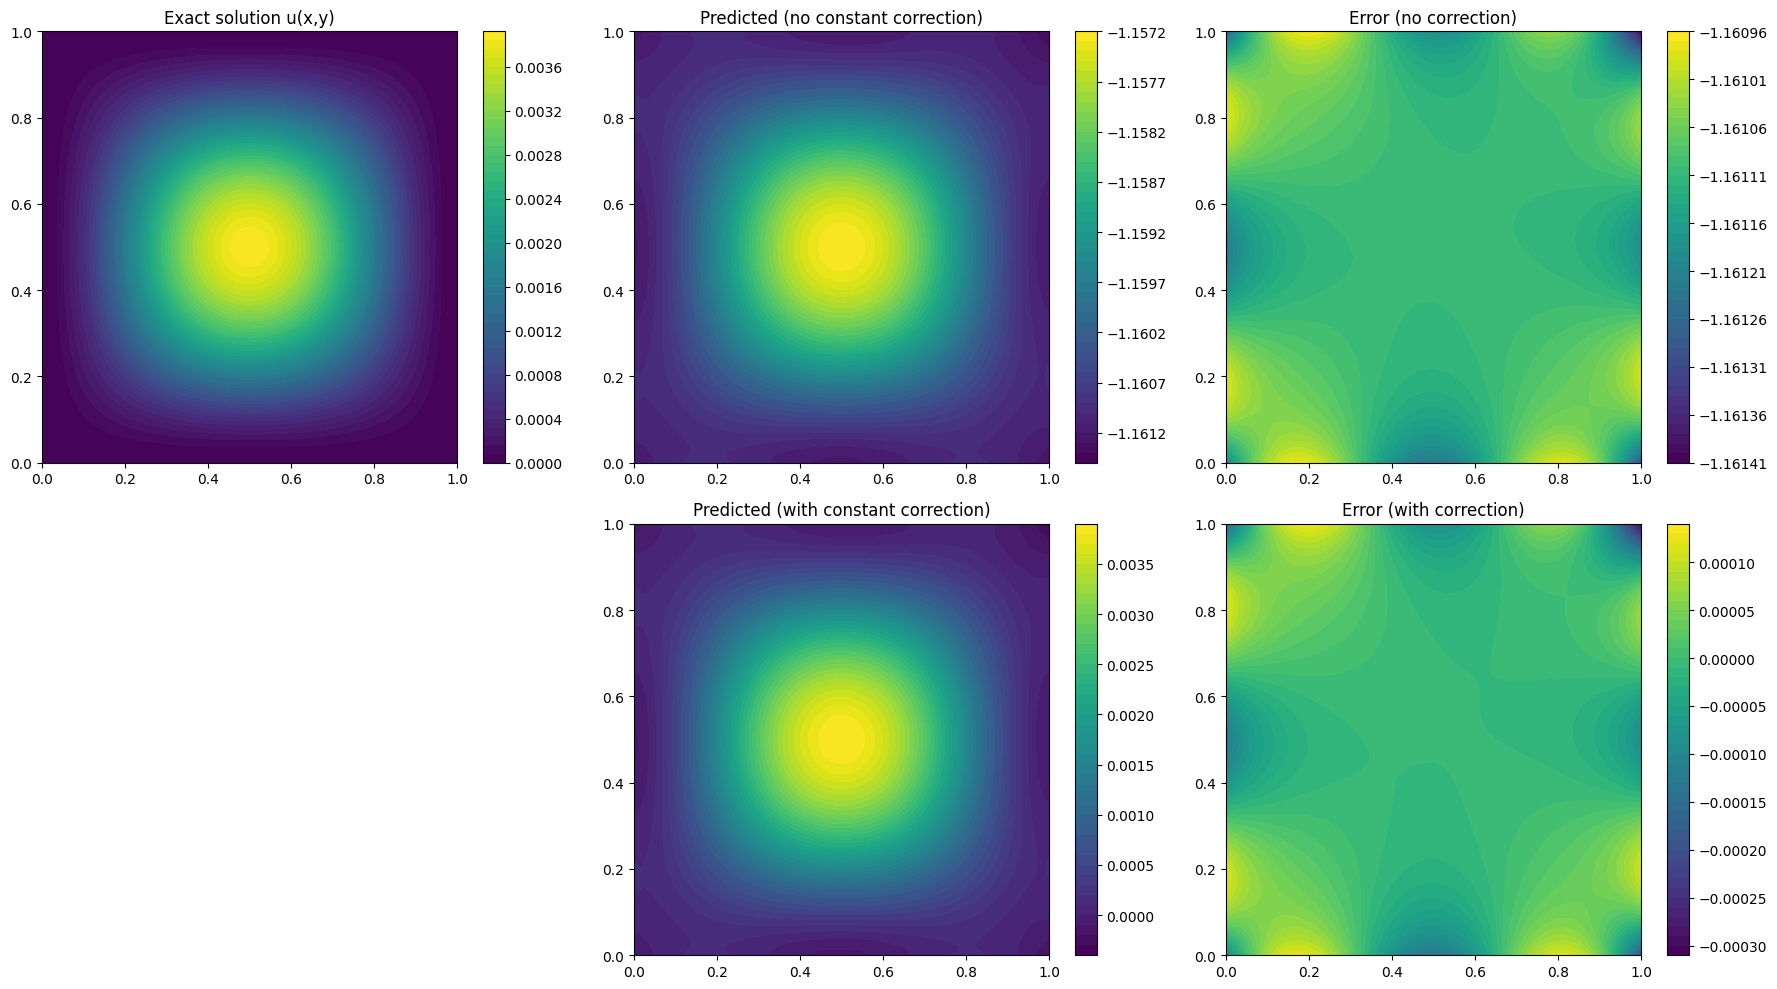

In [ ]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ============================================================
# Setup
# ============================================================
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

out_dir = "p4_example32_pde_residual_results"
os.makedirs(out_dir, exist_ok=True)

# ============================================================
# Autograd helpers: Laplacian and Hessian
# ============================================================
def laplacian(u_vals: torch.Tensor, xy_vals: torch.Tensor) -> torch.Tensor:
    """
    Compute Δu given scalar field u(x,y) and coordinates xy=(x,y).
    u_vals: (N,1), xy_vals: (N,2)
    """
    grad_u = torch.autograd.grad(
        u_vals, xy_vals,
        grad_outputs=torch.ones_like(u_vals),
        create_graph=True
    )[0]  # (N,2)
    ux = grad_u[:, 0:1]
    uy = grad_u[:, 1:2]

    grad_ux = torch.autograd.grad(
        ux, xy_vals,
        grad_outputs=torch.ones_like(ux),
        create_graph=True
    )[0]  # (N,2)
    grad_uy = torch.autograd.grad(
        uy, xy_vals,
        grad_outputs=torch.ones_like(uy),
        create_graph=True
    )[0]  # (N,2)

    u_xx = grad_ux[:, 0:1]
    u_yy = grad_uy[:, 1:2]
    return u_xx + u_yy


def hessian(u_vals: torch.Tensor, xy_vals: torch.Tensor) -> torch.Tensor:
    """
    Compute Hessian H_ij = ∂^2 u / (∂x_i ∂x_j), shape (N,2,2).
    """
    grad_u = torch.autograd.grad(
        u_vals, xy_vals,
        grad_outputs=torch.ones_like(u_vals),
        create_graph=True
    )[0]  # (N,2)

    N = xy_vals.shape[0]
    H = torch.zeros(N, 2, 2, device=xy_vals.device, dtype=xy_vals.dtype)
    for i in range(2):
        comp = grad_u[:, i:i+1]
        grad_comp = torch.autograd.grad(
            comp, xy_vals,
            grad_outputs=torch.ones_like(comp),
            create_graph=True
        )[0]  # (N,2)
        H[:, i, :] = grad_comp
    return H

# ============================================================
# Example 3.2: exact solution and derived data (P4)
#   u(x1,x2) = x1^2 x2^2 (1-x1)^2 (1-x2)^2
#   f = Δ^2 u
#   g1 = ∂u/∂n, g2 = ∂(Δu)/∂n on ∂Ω
# ============================================================
def u_exact_32(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Exact solution u(x,y) for Example 3.2:
        u(x1,x2) = x1^2 x2^2 (1-x1)^2 (1-x2)^2
    """
    return x**2 * y**2 * (1.0 - x)**2 * (1.0 - y)**2


def f_rhs_32(xy: torch.Tensor) -> torch.Tensor:
    """
    Compute f(x,y) = Δ^2 u_exact(x,y) via autograd, then detach (no gradient).
    xy: (N,2)
    """
    xy_req = xy.clone().detach().requires_grad_(True)
    x = xy_req[:, 0:1]
    y = xy_req[:, 1:2]
    u = u_exact_32(x, y)
    lap_u = laplacian(u, xy_req)
    biharm_u = laplacian(lap_u, xy_req)
    return biharm_u.detach()


def boundary_normals(xy: torch.Tensor) -> torch.Tensor:
    """
    Outward unit normal on ∂Ω for the unit square (0,1)^2.
    """
    x = xy[:, 0:1]
    y = xy[:, 1:2]
    n = torch.zeros_like(xy)

    eps = 1e-6
    left = x < eps
    right = x > 1.0 - eps
    bottom = y < eps
    top = y > 1.0 - eps

    if left.any():
        n[left[:, 0]] = torch.tensor([-1.0, 0.0], device=xy.device, dtype=xy.dtype)
    if right.any():
        n[right[:, 0]] = torch.tensor([1.0, 0.0], device=xy.device, dtype=xy.dtype)
    if bottom.any():
        n[bottom[:, 0]] = torch.tensor([0.0, -1.0], device=xy.device, dtype=xy.dtype)
    if top.any():
        n[top[:, 0]] = torch.tensor([0.0, 1.0], device=xy.device, dtype=xy.dtype)

    return n


def exact_g1_g2_32(xy_bd: torch.Tensor):
    """
    g1 = ∂u_exact/∂n
    g2 = ∂(Δu_exact)/∂n
    evaluated at boundary points xy_bd.
    Returns (g1, g2) as (N,1) tensors (detached).
    """
    xy_req = xy_bd.clone().detach().requires_grad_(True)
    x = xy_req[:, 0:1]
    y = xy_req[:, 1:2]

    u = u_exact_32(x, y)
    grad_u = torch.autograd.grad(
        u, xy_req,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]  # (N,2)

    lap_u = laplacian(u, xy_req)
    grad_lap = torch.autograd.grad(
        lap_u, xy_req,
        grad_outputs=torch.ones_like(lap_u),
        create_graph=True
    )[0]  # (N,2)

    n = boundary_normals(xy_req)
    g1 = (grad_u * n).sum(dim=1, keepdim=True)       # ∂u/∂n
    g2 = (grad_lap * n).sum(dim=1, keepdim=True)     # ∂(Δu)/∂n
    return g1.detach(), g2.detach()

# Just for info (not used in loss): approximate mean of exact solution
with torch.no_grad():
    N_mean = 201
    xs_m = torch.linspace(0.0, 1.0, N_mean, device=device)
    ys_m = torch.linspace(0.0, 1.0, N_mean, device=device)
    X_m, Y_m = torch.meshgrid(xs_m, ys_m, indexing="ij")
    Xm_flat = X_m.reshape(-1, 1)
    Ym_flat = Y_m.reshape(-1, 1)
    U_mean_vals = u_exact_32(Xm_flat, Ym_flat)
    U_MEAN_EXACT_32 = U_mean_vals.mean()
print("Approximate mean of u_exact (Example 3.2) on Omega:",
      f"{U_MEAN_EXACT_32.item():.6e}")

# ============================================================
# Network (BiharmonicNet)
# ============================================================
class BiharmonicNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        out = x
        for i in range(len(self.layers) - 1):
            out = self.layers[i](out)
            out = self.activation(out)
        out = self.layers[-1](out)
        return out

layers = [2, 84, 84, 84, 84, 1]
model = BiharmonicNet(layers).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nNetwork architecture:")
print(model)
print(f"\nTotal trainable parameters: {num_params}\n")

# ============================================================
# Sampling points
# ============================================================
def sample_interior(N):
    """
    Uniform random points in Omega = (0,1)^2.
    """
    xy = torch.rand(N, 2, device=device)
    return xy

def sample_boundary(N_per_side):
    """
    Sample boundary points on each side of (0,1)^2.
    Total points = 4 * N_per_side.
    """
    t = torch.rand(N_per_side, 1, device=device)

    left   = torch.cat([torch.zeros_like(t), t], dim=1)        # x=0
    right  = torch.cat([torch.ones_like(t),  t], dim=1)        # x=1
    bottom = torch.cat([t, torch.zeros_like(t)], dim=1)        # y=0
    top    = torch.cat([t, torch.ones_like(t)], dim=1)         # y=1

    xy_bd = torch.cat([left, right, bottom, top], dim=0)
    return xy_bd

# ============================================================
# Losses: PDE residual and BCs (Cahn–Hilliard type)
# ============================================================
LAMBDA_BC1 = 50.0   # weight for BC1 loss (∂u/∂n)
LAMBDA_BC2 = 50.0   # weight for BC2 loss (∂Δu/∂n)

def loss_phys(model, x_int):
    """
    Physics loss: ||Δ^2 u_theta(x) - f(x)||^2 over interior points.
    """
    x_req = x_int.clone().detach().requires_grad_(True)
    u_pred = model(x_req)
    lap_u_pred = laplacian(u_pred, x_req)
    biharm_pred = laplacian(lap_u_pred, x_req)

    f_val = f_rhs_32(x_int)  # detached
    res = biharm_pred - f_val
    return torch.mean(res**2)


def bc_losses(model, x_bd):
    """
    BC losses:
        L_bc1: ||∂u/∂n - g1||^2
        L_bc2: ||∂(Δu)/∂n - g2||^2
    """
    x_req = x_bd.clone().detach().requires_grad_(True)
    u_bd = model(x_req)

    grad_u_bd = torch.autograd.grad(
        u_bd, x_req,
        grad_outputs=torch.ones_like(u_bd),
        create_graph=True
    )[0]  # (Nb,2)

    lap_u_bd = laplacian(u_bd, x_req)

    grad_lap_bd = torch.autograd.grad(
        lap_u_bd, x_req,
        grad_outputs=torch.ones_like(lap_u_bd),
        create_graph=True
    )[0]  # (Nb,2)

    n = boundary_normals(x_req)

    u_n_pred = (grad_u_bd * n).sum(dim=1, keepdim=True)
    lap_u_n_pred = (grad_lap_bd * n).sum(dim=1, keepdim=True)

    g1, g2 = exact_g1_g2_32(x_bd)
    g1 = g1.to(device)
    g2 = g2.to(device)

    res1 = u_n_pred - g1
    res2 = lap_u_n_pred - g2

    L_bc1 = torch.mean(res1**2)
    L_bc2 = torch.mean(res2**2)

    return L_bc1, L_bc2

# ============================================================
# Error metrics: L2, H1, H2 (abs and relative)
# ============================================================
def compute_errors(model, grid_n=81, constant_correction=False):
    """
    Compute L2, H1, H2 absolute and relative errors on a grid.
    If constant_correction=True, we shift u_pred by a constant
    so that mean(u_pred) = mean(u_exact) on the grid.
    """
    xs = torch.linspace(0.0, 1.0, grid_n, device=device)
    ys = torch.linspace(0.0, 1.0, grid_n, device=device)
    X, Y = torch.meshgrid(xs, ys, indexing="ij")
    XY = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)  # (N,2)

    # Predicted solution and its derivatives
    XY_pred = XY.clone().detach().requires_grad_(True)
    u_pred = model(XY_pred)
    grad_pred = torch.autograd.grad(
        u_pred, XY_pred,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True
    )[0]  # (N,2)
    H_pred = hessian(u_pred, XY_pred)

    # Exact solution and its derivatives
    XY_ex = XY.clone().detach().requires_grad_(True)
    x_ex = XY_ex[:, 0:1]
    y_ex = XY_ex[:, 1:2]
    u_ex = u_exact_32(x_ex, y_ex)
    grad_ex = torch.autograd.grad(
        u_ex, XY_ex,
        grad_outputs=torch.ones_like(u_ex),
        create_graph=True
    )[0]  # (N,2)
    H_ex = hessian(u_ex, XY_ex)

    # Constant correction (only shifts u_pred, not gradients/Hessian)
    if constant_correction:
        c = (u_ex.mean() - u_pred.mean()).detach()
        u_pred = u_pred + c

    err_u = u_pred - u_ex
    err_grad = grad_pred - grad_ex
    err_hess = H_pred - H_ex

    L2_abs = torch.sqrt(torch.mean(err_u**2))
    L2_ex = torch.sqrt(torch.mean(u_ex**2))
    L2_rel = L2_abs / (L2_ex + 1e-15)

    H1_abs = torch.sqrt(torch.mean(err_u**2) + torch.mean(err_grad**2))
    H1_ex = torch.sqrt(torch.mean(u_ex**2) + torch.mean(grad_ex**2))
    H1_rel = H1_abs / (H1_ex + 1e-15)

    H2_abs = torch.sqrt(
        torch.mean(err_u**2) +
        torch.mean(err_grad**2) +
        torch.mean(err_hess**2)
    )
    H2_ex = torch.sqrt(
        torch.mean(u_ex**2) +
        torch.mean(grad_ex**2) +
        torch.mean(H_ex**2)
    )
    H2_rel = H2_abs / (H2_ex + 1e-15)

    return (L2_abs.item(), L2_rel.item(),
            H1_abs.item(), H1_rel.item(),
            H2_abs.item(), H2_rel.item())

# ============================================================
# Training (Adam 25k epochs)
# ============================================================
N_INT = 15000          # interior collocation points
N_BD_PER_SIDE = 3000   # boundary points per side => 12000 total
EPOCHS = 25000
PRINT_EVERY = 500

initial_lr = 1.0e-3
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[8000, 16000, 22000],
    gamma=0.7
)

loss_hist = []
phys_hist = []
bc1_hist = []
bc2_hist = []
lr_hist = []

print("\n==========================================================")
print("Training Example 3.2 (P4) with PDE residual + CH BCs")
print("==========================================================")

start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    x_int = sample_interior(N_INT)
    x_bd = sample_boundary(N_BD_PER_SIDE)

    optimizer.zero_grad()

    L_phys = loss_phys(model, x_int)              # PDE residual
    L_bc1, L_bc2 = bc_losses(model, x_bd)         # BC1, BC2
    loss = L_phys + LAMBDA_BC1 * L_bc1 + LAMBDA_BC2 * L_bc2

    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_hist.append(loss.item())
    phys_hist.append(L_phys.item())
    bc1_hist.append(L_bc1.item())
    bc2_hist.append(L_bc2.item())
    lr_hist.append(scheduler.get_last_lr()[0])

    if epoch == 1 or epoch % PRINT_EVERY == 0:
        print(
            f"Epoch {epoch:6d} | "
            f"PDE_loss: {L_phys.item(): .4e} | "
            f"L_bc1: {L_bc1.item(): .4e} | "
            f"L_bc2: {L_bc2.item(): .4e} | "
            f"LR: {scheduler.get_last_lr()[0]:.2e}"
        )

end_time = time.time()
train_time = end_time - start_time
print("\n==========================================================")
print(f"Training finished (Adam) in {train_time:.2f} seconds ({train_time/60.0:.2f} minutes).")
print("==========================================================")

# ============================================================
# LBFGS refinement
# ============================================================
use_lbfgs = True
if use_lbfgs:
    print("\nStarting LBFGS refinement (this may take a while)...")

    x_int_lbfgs = sample_interior(30000)
    x_bd_lbfgs = sample_boundary(5000)

    optimizer_lbfgs = optim.LBFGS(
        model.parameters(),
        lr=1.0,
        max_iter=200,
        history_size=50,
        line_search_fn="strong_wolfe"
    )

    def closure():
        optimizer_lbfgs.zero_grad()
        Lp = loss_phys(model, x_int_lbfgs)
        Lb1, Lb2 = bc_losses(model, x_bd_lbfgs)
        L_tot = Lp + LAMBDA_BC1 * Lb1 + LAMBDA_BC2 * Lb2
        L_tot.backward()
        return L_tot

    optimizer_lbfgs.step(closure)

    # IMPORTANT: do NOT use no_grad here, we need autograd inside loss_phys / bc_losses
    x_int_eval = sample_interior(30000)
    x_bd_eval = sample_boundary(5000)
    Lp_f = loss_phys(model, x_int_eval)
    Lb1_f, Lb2_f = bc_losses(model, x_bd_eval)
    print(
        f"After LBFGS | "
        f"PDE_loss: {Lp_f.item(): .4e} | "
        f"L_bc1: {Lb1_f.item(): .4e} | "
        f"L_bc2: {Lb2_f.item(): .4e}"
    )

# ============================================================
# Final error evaluation: without and with constant correction
# ============================================================
(L2_abs_nc, L2_rel_nc,
 H1_abs_nc, H1_rel_nc,
 H2_abs_nc, H2_rel_nc) = compute_errors(model, grid_n=101, constant_correction=False)

(L2_abs_c, L2_rel_c,
 H1_abs_c, H1_rel_c,
 H2_abs_c, H2_rel_c) = compute_errors(model, grid_n=101, constant_correction=True)

print("\n==========================================================")
print("Final error metrics (no constant correction, N_grid=101):")
print(f"  L2_abs = {L2_abs_nc:.6e}")
print(f"  L2_rel = {L2_rel_nc:.6e}")
print(f"  H1_abs = {H1_abs_nc:.6e}")
print(f"  H1_rel = {H1_rel_nc:.6e}")
print(f"  H2_abs = {H2_abs_nc:.6e}")
print(f"  H2_rel = {H2_rel_nc:.6e}")

print("\nFinal error metrics (with constant correction, N_grid=101):")
print(f"  L2_abs = {L2_abs_c:.6e}")
print(f"  L2_rel = {L2_rel_c:.6e}")
print(f"  H1_abs = {H1_abs_c:.6e}")
print(f"  H1_rel = {H1_rel_c:.6e}")
print(f"  H2_abs = {H2_abs_c:.6e}")
print(f"  H2_rel = {H2_rel_c:.6e}")
print("==========================================================\n")

# ============================================================
# Plots: loss history + solutions before/after constant correction
# ============================================================
epochs_arr = np.arange(1, EPOCHS + 1)

plt.figure(figsize=(8, 5))
plt.semilogy(epochs_arr, np.abs(loss_hist))
plt.xlabel("Epoch")
plt.ylabel("|Total loss|")
plt.title("Total loss history (Example 3.2, P4)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "loss_history_total.png"), dpi=200)
plt.show()

plt.figure(figsize=(8, 5))
plt.semilogy(epochs_arr, np.abs(phys_hist), label="PDE_loss")
plt.semilogy(epochs_arr, np.abs(bc1_hist), label="L_bc1")
plt.semilogy(epochs_arr, np.abs(bc2_hist), label="L_bc2")
plt.xlabel("Epoch")
plt.ylabel("Loss components")
plt.title("Loss components history (Example 3.2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "loss_components.png"), dpi=200)
plt.show()

# Solution plots
grid_n_plot = 101
xs_p = torch.linspace(0.0, 1.0, grid_n_plot, device=device)
ys_p = torch.linspace(0.0, 1.0, grid_n_plot, device=device)
X_p, Y_p = torch.meshgrid(xs_p, ys_p, indexing="ij")
XY_p = torch.stack([X_p.reshape(-1), Y_p.reshape(-1)], dim=1)

with torch.no_grad():
    x_flat = XY_p[:, 0:1]
    y_flat = XY_p[:, 1:2]
    U_ex_flat = u_exact_32(x_flat, y_flat)

    U_pred_flat = model(XY_p)
    c_corr = (U_ex_flat.mean() - U_pred_flat.mean())
    U_pred_corr_flat = U_pred_flat + c_corr

U_ex = U_ex_flat.reshape(grid_n_plot, grid_n_plot).cpu().numpy()
U_pred_nc = U_pred_flat.reshape(grid_n_plot, grid_n_plot).cpu().numpy()
U_pred_c = U_pred_corr_flat.reshape(grid_n_plot, grid_n_plot).cpu().numpy()

X_np = X_p.cpu().numpy()
Y_np = Y_p.cpu().numpy()

err_nc = U_pred_nc - U_ex
err_c = U_pred_c - U_ex

# 2D contour plots
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
cp1 = plt.contourf(X_np, Y_np, U_ex, levels=50)
plt.colorbar(cp1)
plt.title("Exact solution u(x,y)")

plt.subplot(2, 3, 2)
cp2 = plt.contourf(X_np, Y_np, U_pred_nc, levels=50)
plt.colorbar(cp2)
plt.title("Predicted (no constant correction)")

plt.subplot(2, 3, 3)
cp3 = plt.contourf(X_np, Y_np, err_nc, levels=50)
plt.colorbar(cp3)
plt.title("Error (no correction)")

plt.subplot(2, 3, 5)
cp5 = plt.contourf(X_np, Y_np, U_pred_c, levels=50)
plt.colorbar(cp5)
plt.title("Predicted (with constant correction)")

plt.subplot(2, 3, 6)
cp6 = plt.contourf(X_np, Y_np, err_c, levels=50)
plt.colorbar(cp6)
plt.title("Error (with correction)")

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "solutions_contours_before_after_corr.png"), dpi=200)
plt.show()

# 3D surface of corrected solution
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_np, Y_np, U_pred_c, linewidth=0, antialiased=True)
ax.set_title("Predicted solution with constant correction (3D)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u_theta(x,y)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "solution_3d_corrected.png"), dpi=200)
plt.show()
